# Data Analysis and Data Science Notebook Ambientando Fiestas

Este notebook está dedicado al análisis y exploración del conjunto de datos proporcionado mediante la extracción de información de la API de WooCommerce y SharePoints Lists. Su objetivo es aplicar metodologías de ciencia de datos para descubrir percepciones, tendencias y patrones que puedan informar los procesos de toma de decisiones.

In [693]:
import pandas as pd
pd.set_option('display.max_columns', 5)
import json
import matplotlib.pyplot as plt
import seaborn as sns

## Contexto Comercial

## Problema Comercial

1) ¿Cuánto tiempo antes al día del evento reserva la gente?​
2) Se requieren visualizar cantidad de fiestas por mes​
3) ¿Cómo determino cuál es el momento que más gente necesito contratar?​
4) ¿Cómo determinar cantidad de personal por zona​
5) ¿La gente reincide con la organización? ¿Compra los mismos productos?​

# 6) Data wrangling

## Descargar los archivos .csv
Obtenemos la información de dos archivos csv los cuales son importados desde dos fuentes de datos:
- API WooCommerce -> e-commerce utilizado por la organización para realizar los pedidos.
- API SharePoint -> Base de datos del sistema de gestión interno que permite hacer una trazabilidad de los eventos

In [694]:
df_pedidos_wc =pd.read_csv('pedidos_wc.csv')
df_pedidos_sh = pd.read_csv('pedidos_sh.csv')

# Combinar los archivos​

Unificamos los key de cada uno para poder realizar la combinación

Combinamos los archivos de Sharepoint y WooCommerce para poder tener un dataset unificado y verificar el estado del dataset.


In [695]:
df_pedidos_wc = df_pedidos_wc.rename(columns={"id":"Title"})
df_pedidos_sh['Title'] = df_pedidos_sh['Title'].astype(int)
df_pedidos_wc_sh = pd.merge(df_pedidos_wc,df_pedidos_sh,left_on='Title',right_on='Title',how='left')
df_pedidos_wc_sh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3617 entries, 0 to 3616
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3617 non-null   int64  
 1   parent_id             3617 non-null   int64  
 2   status                3617 non-null   object 
 3   currency              3617 non-null   object 
 4   version               3617 non-null   object 
 5   prices_include_tax    3617 non-null   bool   
 6   date_created          3617 non-null   object 
 7   date_modified         3617 non-null   object 
 8   discount_total        3617 non-null   int64  
 9   discount_tax          3617 non-null   int64  
 10  shipping_total        3617 non-null   int64  
 11  shipping_tax          3617 non-null   int64  
 12  cart_tax              3617 non-null   int64  
 13  total                 3617 non-null   int64  
 14  total_tax             3617 non-null   int64  
 15  customer_id          

In [696]:
print(f"Total registros: {len(df_pedidos_wc_sh['Title'].values)}")
print(f"Fecha creación primer pedido: {df_pedidos_wc_sh['date_created'].sort_values()[:1].values}")
print(f"Fecha creación primer pedido: {df_pedidos_wc_sh['date_created'].sort_values(ascending=False)[:1].values}")

Total registros: 3617
Fecha creación primer pedido: ['2022-02-10T18:02:36']
Fecha creación primer pedido: ['2024-06-12T18:25:46']


# Limpieza de datos

### Eliminar columnas innecesarias
Empezamos removiendo las columnas que sabemos que no nos van a aportar información

In [697]:
columns_drop_customer = ['customer_id','customer_ip_address','parent_id','first_name','last_name','company','country','email','phone','billing_first_name','dni','Usuario']
columns_drop_ship_tax = ['shipping','shipping_total','shipping_tax','cart_tax','total_tax','prices_include_tax','shipping_tax','discount_tax','prices_include_tax','currency','tax_lines','shipping_lines','coupon_lines','refunds','billing','needs_payment']
columns_drop_pedido = ['version','order_key','discount_total','transaction_id','customer_user_agent','cart_hash','number','payment_url','is_editable','needs_processing','_links','line_items','fee_lines']
columns_drop_dates = ['date_completed','meta_data']
drop_columns=[]
drop_columns = columns_drop_customer + columns_drop_ship_tax  + columns_drop_pedido + columns_drop_dates
df_pedidos_wc_sh = df_pedidos_wc_sh.drop(columns=drop_columns,axis=1)
df_pedidos_wc_sh.head()

,Title,status,...,Lugar,Created
0,10008,on-hold,...,NaN,NaN
1,10007,processing,...,NaN,2024-06-12T13:38:48Z
2,10005,processing,...,Quinta,2024-06-12T11:08:16Z
3,10004,processing,...,NaN,2024-06-12T12:57:09Z
4,10002,processing,...,Casa,2024-06-11T21:35:13Z


### Detección de valores erróneos
Hay una serie de estados que no vamos a utilizar ya que se tratan de pedidos que no aportan información a los eventos según nos dijeron desde la organización.
Primero vamos a ver todos los estados

In [698]:
df_pedidos_wc_sh['status'].unique()

array(['on-hold', 'processing', 'cancelled', 'pending', 'presencial',
       'failed', 'refunded', 'pasteleria', 'completed', 'inflable',
       'confirmado', '427contenidodig', 'retiro', 'jesica-silva'],
      dtype=object)

In [699]:
df_pedidos_wc_sh.groupby(['status'])['status'].count()

status
427contenidodig      22
cancelled           167
completed           190
confirmado          967
failed              100
inflable             62
jesica-silva          1
on-hold              27
pasteleria           34
pending               3
presencial           22
processing         1869
refunded            141
retiro               12
Name: status, dtype: int64

Los que vamos a sacar luego de conversar con la organización son:
- presencial 
- jesica-silva

In [700]:
status_a_eliminar = ['jesica-silva','presencial']
df_pedidos_wc_sh = df_pedidos_wc_sh[~df_pedidos_wc_sh['status'].isin(status_a_eliminar)]

### Conversión de datos correspondientes en campos de fecha​

In [701]:
columns_to_convert = ['date_created', 'date_modified',  'date_paid','Inicio_evento', 'Fin_evento','Created']
df_pedidos_wc_sh[columns_to_convert] = df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)

In [702]:
df_pedidos_wc_sh = df_pedidos_wc_sh.rename({'Inicio_evento':'Inicio_evento_wc'})

df_pedidos_wc_sh['Inicio_evento_merge'] = df_pedidos_wc_sh['Inicio_evento_wc'].combine_first(df_pedidos_wc_sh['Inicio_evento'])
#Eliminamos los Inicios de eventos sin combinar
df_pedidos_wc_sh = df_pedidos_wc_sh.drop(columns=['Inicio_evento','Inicio_evento_wc'],axis=1)
df_pedidos_wc_sh= df_pedidos_wc_sh.rename(columns={"Inicio_evento_merge":"Inicio_evento"})
df_pedidos_wc_sh = df_pedidos_wc_sh.set_index('Title')

In [703]:
df_pedidos_wc_sh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3594 entries, 10008 to 2253
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   status                3594 non-null   object             
 1   date_created          3594 non-null   datetime64[ns, UTC]
 2   date_modified         3594 non-null   datetime64[ns, UTC]
 3   total                 3594 non-null   int64              
 4   payment_method        3046 non-null   object             
 5   payment_method_title  3046 non-null   object             
 6   created_via           3589 non-null   object             
 7   customer_note         2465 non-null   object             
 8   date_paid             3078 non-null   datetime64[ns, UTC]
 9   date_created_gmt      3594 non-null   object             
 10  date_modified_gmt     3594 non-null   object             
 11  date_completed_gmt    534 non-null    object             
 12  date_pa

# 7) Resolución problemas de negocio​  

## ¿Cuánto tiempo antes al día del evento reserva la gente?

## Datos faltantes de fecha del inicio del evento

Generamos una función que nos devuelva información acerca de los datos faltantes

In [704]:
def missing_values_info(df,column_name):
    total_values = df.shape[0]
    total_missing_values = df[df[column_name].isna()].shape[0]
    perc_missing_values = format(total_missing_values / total_values * 100, ".2f")
    print(f"Pedidos sin dato de fecha del evento -> {total_missing_values} de {total_values} - ({perc_missing_values} %)")

In [705]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 1484 de 3594 - (41.29 %)


In [706]:
df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento'].isna()]

,status,date_created,...,Created,Inicio_evento
Title,,,,,
9986,cancelled,2024-06-09 15:32:40+00:00,...,NaT,NaT
9985,cancelled,2024-06-09 15:12:47+00:00,...,NaT,NaT
9984,pending,2024-06-09 14:56:14+00:00,...,NaT,NaT
9741,cancelled,2024-05-14 16:40:06+00:00,...,NaT,NaT
9738,cancelled,2024-05-14 16:15:39+00:00,...,NaT,NaT
...,...,...,...,...,...
2562,completed,2022-02-22 13:32:40+00:00,...,NaT,NaT
2492,completed,2022-02-16 13:59:53+00:00,...,NaT,NaT
2414,completed,2022-02-15 15:11:52+00:00,...,NaT,NaT


## Eventos sin fecha de inicio

- ¿Por qué tenemos eventos que no tienen dato de fecha?

Filtramos los datos donde no hay dato del evento para entender la razón y agrupamos por la fecha en que fueron creados

/tmp/ipykernel_43421/2265077564.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')


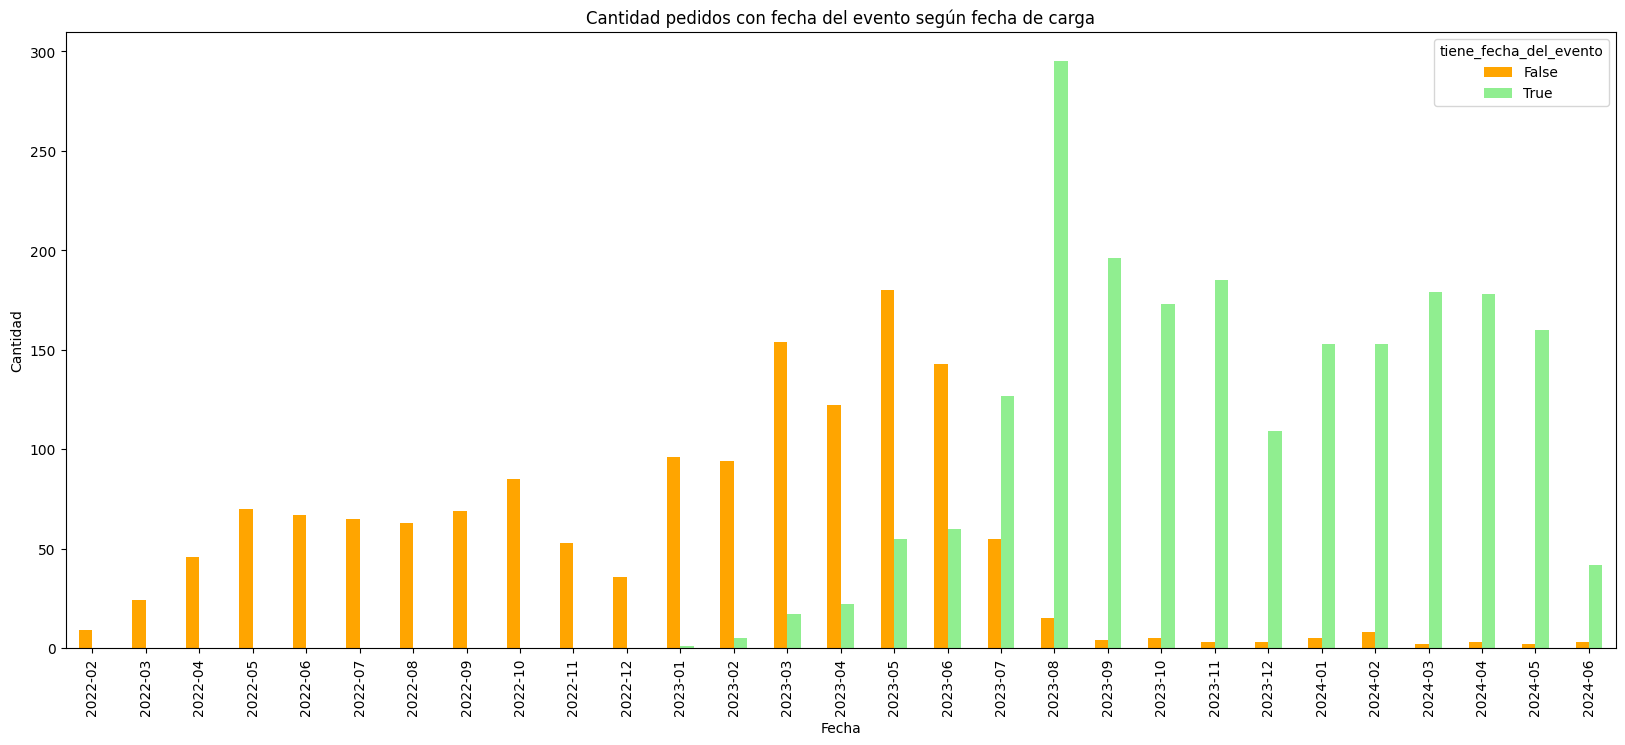

In [707]:
import pandas as pd
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,8))
df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)
df_pedidos_con_o_sin_fecha_evento = df_pedidos_wc_sh.copy()
df_pedidos_con_o_sin_fecha_evento['tiene_fecha_del_evento'] = df_pedidos_con_o_sin_fecha_evento['Inicio_evento'].notna()

df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')

conteo_mes_estado_fecha = df_pedidos_con_o_sin_fecha_evento.groupby(['mes','tiene_fecha_del_evento']).size().unstack(fill_value=0)


# Graficar
conteo_mes_estado_fecha.plot(kind='bar',ax=ax,color=['orange','lightgreen'])
ax.set_title("Cantidad pedidos con fecha del evento según fecha de carga")
ax.set_xlabel("Fecha")
ax.set_ylabel("Cantidad")
plt.show()

### Conclusión faltantes de dato de fecha del evento
Podemos ver que los eventos cargados previo al 2023-08 tienen muchos eventos sin fecha del evento.
El sistema interno (App gestión interna​) comenzó a estar en funcionamiento durante ese mes. Y es a partir de esta fecha en la que casi todos los eventos tienen carga correspondiente.

Para obtener las fechas del evento vamos a realizar los siguientes filtros:
- Eventos donde no esté el dato de Inicio_evento
- Eventos donde hay una nota del cliente (customer note). En este campo podemos encontrar información de la fecha del evento

In [708]:
df_pedidos_fecha_evento = df_pedidos_wc_sh[(df_pedidos_wc_sh['Inicio_evento'].isna())  & (df_pedidos_wc_sh['customer_note'].notna())]
df_pedidos_fecha_evento['customer_note']

Title
9986    Rufina \r\nSábado 3/8\r\n3 años \r\n15 a 18 hs...
9985    Nombre de la homenajeada: Catia\r\n.       Cua...
9984    Datos del evento:28 de junio\r\n•\tNombre de d...
9458    Nombre de del homenajeado: Juan Martín Bilski\...
9403    Cuantos años cumple: 1 año\r\n•\tFecha 21/04\r...
                              ...                        
2704          Agregar panel lateral: tematica La sirenita
2635    Montaje infantil encanto con flores de globos ...
2573       Montaje infantil premium animales de la selva.
2563    temática elefante con globo aerostatico como e...
2492                                   la granja de zenon
Name: customer_note, Length: 1100, dtype: object

## Obtención de datos de fecha del customer note
Aplicamos regex para poder encontrar los datos de fecha.
- El patrón que se puede ver es:
    - 28 de junio ({nro_dia} de {nombre_mes})
    - 10/08/2024
    - 16 marzo ({nro_dia} {nombre_mes})
    - 26.11.23 ({nro_dia}.{nro_mes}.{nro_año})
    

In [709]:
pattern = r'\b(\d{1,2} de [a-zA-Z]+(?!\s*HS)|\d{1,2}(?:/\d{1,2})?/\d{2,4}|\d{1,2}\.\d{1,2}\.\d{2,4})\b'
# Extraer fechas usando el patrón regex
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['customer_note'].str.extract(pattern)

In [710]:
print(f"Fechas encontradas con regex: {df_pedidos_wc_sh['fecha'].notna().sum()}")
print(f"Fechas NO encontradas con regex: {df_pedidos_wc_sh['fecha'].isna().sum()}")

Fechas encontradas con regex: 1433
Fechas NO encontradas con regex: 2161


In [711]:
def evaluar_fecha_correcta(data):
    try: 
        return pd.to_datetime(data, errors='coerce')
    except:
        return pd.NaT

In [712]:
df_pedidos_wc_sh['fecha_complete'] = df_pedidos_wc_sh['fecha'].apply(evaluar_fecha_correcta)

/tmp/ipykernel_43421/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')
/tmp/ipykernel_43421/4075736083.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')


In [713]:
df_pedidos_wc_sh['fecha_complete'].unique()

<DatetimeArray>
[                'NaT', '2024-06-07 00:00:00', '2024-10-27 00:00:00',
 '2024-10-08 00:00:00', '2024-06-30 00:00:00', '2024-08-06 00:00:00',
 '2024-06-29 00:00:00', '2024-10-06 00:00:00', '2024-03-11 00:00:00',
 '2024-08-31 00:00:00',
 ...
 '2022-11-06 00:00:00', '2022-05-06 00:00:00', '2022-04-06 00:00:00',
 '2022-10-07 00:00:00', '2022-04-19 00:00:00', '2022-05-22 00:00:00',
 '2022-05-25 00:00:00', '2022-08-05 00:00:00', '2022-08-14 00:00:00',
 '2022-09-07 00:00:00']
Length: 319, dtype: datetime64[ns]

Completamos la columnas inicio_evento con las fechas recuperadas

In [714]:
df_pedidos_wc_sh.reset_index(drop=True, inplace=True)
df_pedidos_wc_sh.loc[df_pedidos_wc_sh['Inicio_evento'].isna(), 'Inicio_evento'] = df_pedidos_wc_sh['fecha_complete']

In [715]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 1226 de 3594 - (34.11 %)


In [716]:
df_pedidos_wc_sh[df_pedidos_wc_sh['fecha_complete'].isna()]

,status,date_created,...,fecha,fecha_complete
0,on-hold,2024-06-12 18:25:46+00:00,...,NaN,NaT
1,processing,2024-06-12 13:35:45+00:00,...,NaN,NaT
2,processing,2024-06-12 11:06:33+00:00,...,NaN,NaT
3,processing,2024-06-11 23:35:50+00:00,...,7 de septiembre,NaT
4,processing,2024-06-11 17:35:37+00:00,...,10 de agosto,NaT
...,...,...,...,...,...
3589,completed,2022-02-22 13:32:40+00:00,...,NaN,NaT
3590,completed,2022-02-16 13:59:53+00:00,...,NaN,NaT
3591,completed,2022-02-15 15:11:52+00:00,...,NaN,NaT
3592,completed,2022-02-11 16:55:21+00:00,...,NaN,NaT


### Convertimos en inglés las fechas para poder agregarle el año

In [717]:
def convertir_fecha(fecha):
    meses = {
        'enero': 'jan', 'febrero': 'feb', 'marzo': 'mar', 'abril': 'apr',
        'mayo': 'May', 'junio': 'jun', 'julio': 'Jul', 'agosto': 'aug',
        'septiembre': 'sep', 'octubre': 'oct', 'noviembre': 'Nov', 'diciembre': 'dec'
    }
  
    try:
        fecha = fecha.lower()
        dia, de, mes = fecha.split()
        if de=='de':
            mes_ingles = meses[mes]

            fecha_ingles = f"{mes_ingles} {dia}"
    
            return fecha_ingles

            
        else:
            return fecha
    except:
        return fecha

In [718]:
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].apply(convertir_fecha)

## Funcion que agrega el año

- Hay dos formas:
    - {nro_mes} / {nro_anio}
    - {name_mes} {nro_dia}

In [726]:
def agregar_ultimo_caracter(data):
    try:
        if "/" in data:
            return data + "/"
        else:
            return data + " "
    except:
        return data

In [727]:
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].apply(agregar_ultimo_caracter)

In [728]:
df_pedidos_wc_sh['anio_evento_temp'] = (df_pedidos_wc_sh['date_created'].dt.year).astype(str)
df_pedidos_wc_sh['fecha'] = df_pedidos_wc_sh['fecha'].str.cat(df_pedidos_wc_sh['anio_evento_temp'], sep='')

df_pedidos_wc_sh

,status,date_created,...,fecha_complete,anio_evento_temp
0,on-hold,2024-06-12 18:25:46+00:00,...,NaT,2024
1,processing,2024-06-12 13:35:45+00:00,...,NaT,2024
2,processing,2024-06-12 11:06:33+00:00,...,NaT,2024
3,processing,2024-06-11 23:35:50+00:00,...,2024-09-07,2024
4,processing,2024-06-11 17:35:37+00:00,...,2024-08-10,2024
...,...,...,...,...,...
3589,completed,2022-02-22 13:32:40+00:00,...,NaT,2022
3590,completed,2022-02-16 13:59:53+00:00,...,NaT,2022
3591,completed,2022-02-15 15:11:52+00:00,...,NaT,2022
3592,completed,2022-02-11 16:55:21+00:00,...,NaT,2022


In [729]:
df_pedidos_wc_sh['fecha_complete'] = df_pedidos_wc_sh['fecha'].apply(evaluar_fecha_correcta)

/tmp/ipykernel_43421/4075736083.py:3: UserWarning: Parsing dates in %d/%m/%H%M/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(data, errors='coerce')


In [730]:
df_pedidos_wc_sh.reset_index(drop=True, inplace=True)
df_pedidos_wc_sh.loc[df_pedidos_wc_sh['Inicio_evento'].isna(), 'Inicio_evento'] = df_pedidos_wc_sh['fecha_complete']

In [731]:
missing_values_info(df_pedidos_wc_sh,'Inicio_evento')

Pedidos sin dato de fecha del evento -> 839 de 3594 - (23.34 %)


In [732]:

df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento'].notna()]

,status,date_created,...,fecha_complete,anio_evento_temp
0,on-hold,2024-06-12 18:25:46+00:00,...,NaT,2024
1,processing,2024-06-12 13:35:45+00:00,...,NaT,2024
2,processing,2024-06-12 11:06:33+00:00,...,NaT,2024
3,processing,2024-06-11 23:35:50+00:00,...,2024-09-07 20:24:00,2024
4,processing,2024-06-11 17:35:37+00:00,...,2024-08-10 20:24:00,2024
...,...,...,...,...,...
3566,completed,2022-03-29 16:28:50+00:00,...,2022-05-09 20:22:00,2022
3571,confirmado,2022-03-27 17:33:47+00:00,...,2022-07-08 20:22:00,2022
3580,refunded,2022-03-21 14:34:14+00:00,...,2022-06-18 20:22:00,2022
3583,completed,2022-03-11 14:11:45+00:00,...,2022-04-24 20:22:00,2022


/tmp/ipykernel_43421/2265077564.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')


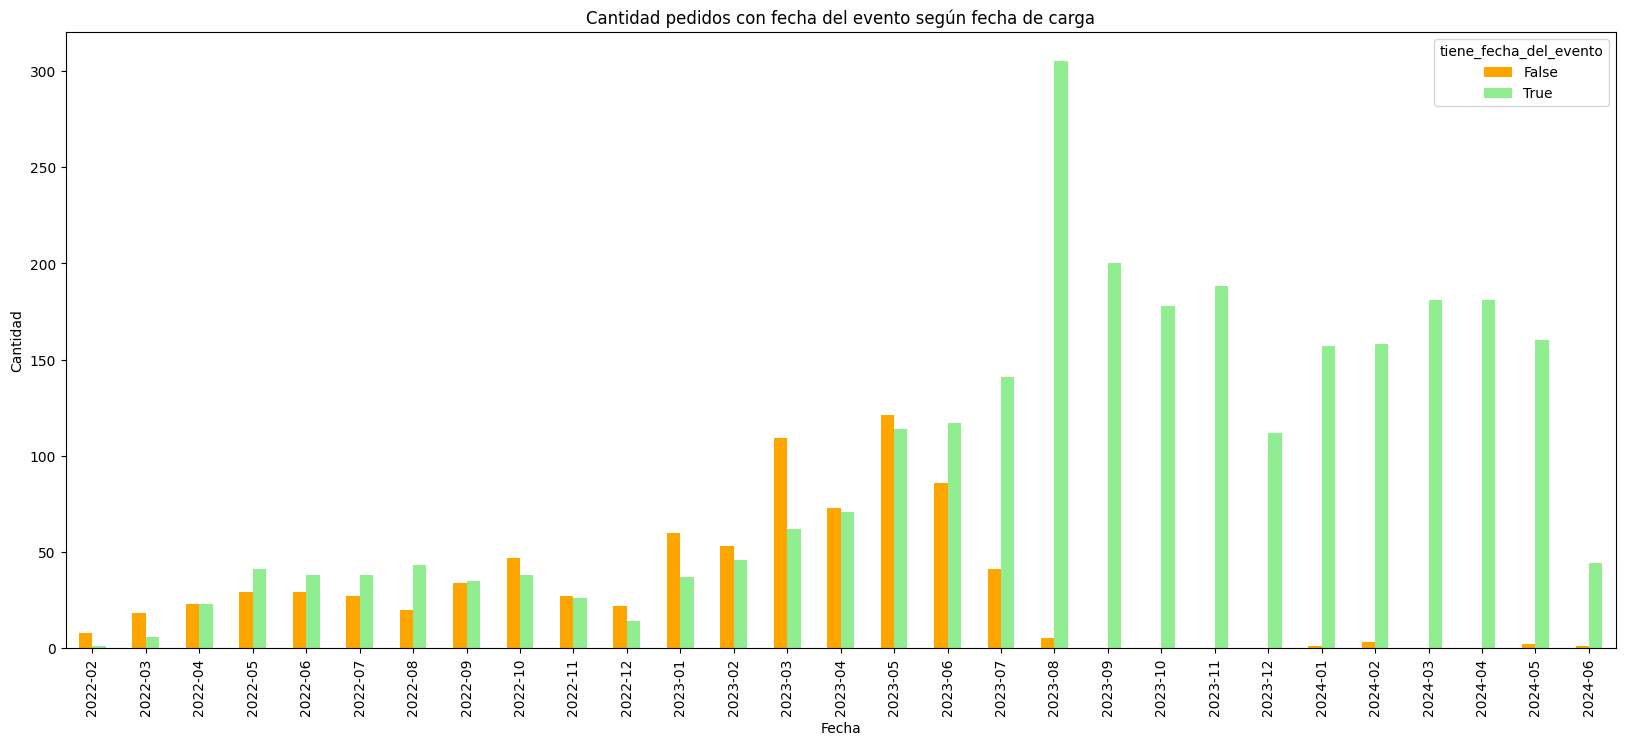

In [691]:
import pandas as pd
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(20,8))
df_pedidos_wc_sh[columns_to_convert].apply(pd.to_datetime,utc=True)
df_pedidos_con_o_sin_fecha_evento = df_pedidos_wc_sh.copy()
df_pedidos_con_o_sin_fecha_evento['tiene_fecha_del_evento'] = df_pedidos_con_o_sin_fecha_evento['Inicio_evento'].notna()

df_pedidos_con_o_sin_fecha_evento['mes'] = df_pedidos_con_o_sin_fecha_evento['date_created'].dt.to_period('M')

conteo_mes_estado_fecha = df_pedidos_con_o_sin_fecha_evento.groupby(['mes','tiene_fecha_del_evento']).size().unstack(fill_value=0)


# Graficar
conteo_mes_estado_fecha.plot(kind='bar',ax=ax,color=['orange','lightgreen'])
ax.set_title("Cantidad pedidos con fecha del evento según fecha de carga")
ax.set_xlabel("Fecha")
ax.set_ylabel("Cantidad")
plt.show()

## 1) ¿Cuánto tiempo antes reserva la gente al día del evento?
Calculamos para todos los eventos donde hay dato del inicio del evento


In [542]:
df_pedidos_wc_sh =  df_pedidos_wc_sh[df_pedidos_wc_sh['Inicio_evento'].notna()]

In [543]:
df_pedidos_wc_sh[['Inicio_evento','date_created']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Inicio_evento  2755 non-null   object             
 1   date_created   2755 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 64.6+ KB


Convertimos los campos al mismo tipo

In [544]:
df_pedidos_wc_sh['Inicio_evento'] = pd.to_datetime(df_pedidos_wc_sh['Inicio_evento']).dt.tz_localize(None)

ValueError: Cannot mix tz-aware with tz-naive values, at position 16. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

### Calculo del tiempo de anticipación de reserva de un evento

In [138]:
df_pedidos_wc_sh['anticipacion_reserva_dias'] = (df_pedidos_wc_sh['Inicio_evento'] -df_pedidos_wc_sh['date_created'].dt.tz_convert(None)).dt.days

/tmp/ipykernel_43421/137753054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pedidos_wc_sh['anticipacion_reserva_dias'] = (df_pedidos_wc_sh['Inicio_evento'] -df_pedidos_wc_sh['date_created'].dt.tz_convert(None)).dt.days


## Verificación de datos outliers

In [139]:
df_pedidos_wc_sh

,Title,status,date_created,date_modified,total,payment_method,payment_method_title,created_via,customer_note,date_paid,date_created_gmt,date_modified_gmt,date_completed_gmt,date_paid_gmt,currency_symbol,address_1,address_2,city,state,postcode,billing_horario,finalizacion,billing_tematica,billing_nombre,billing_edad,billing_lugar,Estado,Edad,Tematica,Fin_evento,Lugar,Created,Inicio_evento,fecha,fecha_complete,anio_evento_temp,anticipacion_reserva_dias
0,10008,on-hold,2024-06-12 18:25:46+00:00,2024-06-12 18:25:46+00:00,420000,bacs,Transferencia bancaria -20%,checkout,NaN,NaT,2024-06-12T18:25:46,2024-06-12T18:25:46,NaN,NaN,$,Sum 1. Barrio Costas. Puertos del Lago,NaN,Escobar,NaN,NaN,13:00,16:00,Safari,Danae,6,SUM,NaN,NaN,NaN,NaT,NaN,NaT,2024-07-13 00:00:00,NaN,NaT,2024,30
1,10007,processing,2024-06-12 13:35:45+00:00,2024-06-12 13:37:11+00:00,198000,NaN,NaN,admin,Nombre de del homenajeado/a Lola \r\n. ...,2024-06-12 13:37:11+00:00,2024-06-12T13:35:45,2024-06-12T13:37:11,NaN,2024-06-12T13:37:11,$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pendiente,0.0,NaN,NaT,NaN,2024-06-12 13:38:48+00:00,2024-06-12 13:35:45,NaN,NaT,2024,0
2,10005,processing,2024-06-12 11:06:33+00:00,2024-06-12 11:07:29+00:00,229000,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,Me contactan para coordinar sobre la temática ...,2024-06-12 11:07:29+00:00,2024-06-12T11:06:33,2024-06-12T11:07:29,NaN,2024-06-12T11:07:29,$,José Hernández 1443 esquina uruguay,NaN,Escobar,NaN,NaN,13:00,17:00,Osito nórdico,Piero,1,Quinta,pendiente,1.0,Osito nórdico,2024-07-13 20:00:00+00:00,Quinta,2024-06-12 11:08:16+00:00,2024-07-13 00:00:00,NaN,NaT,2024,30
3,10004,processing,2024-06-11 23:35:50+00:00,2024-06-12 12:56:31+00:00,216000,NaN,NaN,admin,Olivia Encalada\r\n2 años \r\nSábado 7 de sept...,2024-06-12 12:56:31+00:00,2024-06-11T23:35:50,2024-06-12T12:56:31,NaN,2024-06-12T12:56:31,$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pendiente,0.0,NaN,NaT,NaN,2024-06-12 12:57:09+00:00,2024-06-11 23:35:50,sep 7 2024,NaT,2024,0
4,10002,processing,2024-06-11 17:35:37+00:00,2024-06-11 21:33:38+00:00,390000,NaN,NaN,admin,Homenajeado\r\nFacundo \r\nCumple 1 año\r\nDe ...,2024-06-11 21:33:38+00:00,2024-06-11T17:35:37,2024-06-11T21:33:38,NaN,2024-06-11T21:33:38,$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmado,1.0,koala,2024-08-10 23:00:00+00:00,Casa,2024-06-11 21:35:13+00:00,2024-08-10 18:00:00,aug 10 2024,NaT,2024,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813,5211,processing,2023-02-28 16:33:43+00:00,2023-08-18 13:37:08+00:00,42000,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,admin,Datos del evento:\r\n•\tNombre de del homenaje...,2023-02-28 16:35:07+00:00,2023-02-28T16:33:43,2023-08-18T13:37:08,NaN,2023-02-28T16:35:07,$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,finalizado,1.0,Rey León,2023-09-01 03:00:00+00:00,Salón,2023-11-03 12:58:17+00:00,2023-09-01 20:00:00,1/9/23/2023,NaT,2023,185
2822,5201,processing,2023-02-28 02:58:47+00:00,2023-08-28 20:51:21+00:00,135000,woo-mercado-pago-custom,Paga con tarjetas de crédito hasta 6 cuotas si...,checkout,La dirección es de mi domicilio pero nuestra i...,2023-02-28 02:59:45+00:00,2023-02-28T02:58:47,2023-08-28T20:51:21,NaN,2023-02-28T02:59:45,$,Juan Farrel 784,NaN,Valentín Alsina,NaN,1822,NaN,NaN,Cars,Giovanni,2,NaN,finalizado,2.0,Cars,2023-09-05 03:00:00+00:00,Salón,2023-11-03 13:12:45+00:00,2023-09-06 02:58:00,NaN,NaT,2023,189
2849,5157,processing,2023-02-17 15:28:27+00:00,2023-09-04 17:13:58+00:00,39000,other,Otro,admin,Datos del evento:\r\n•\tNombre de del homenaje...,2023-02-17 15:32:52+00:00,2023-02-17T15:28:27,2023-09-04T17:13:58,NaN,2023-02-17T15:32:52,$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,completado,1.0,mickey,2023-09-23 03:00:00+00:00,Salón,2023-11-03 13:21:25+00:00,2023-09-23 15:30:00,23/09/2023/2023,NaT,2023,218
2852,5154,processing,2023-02-17 14:00:3

## Box plot Anticipación de reserva de pedidos

Text(0.5, 0, 'Días de anticipación')

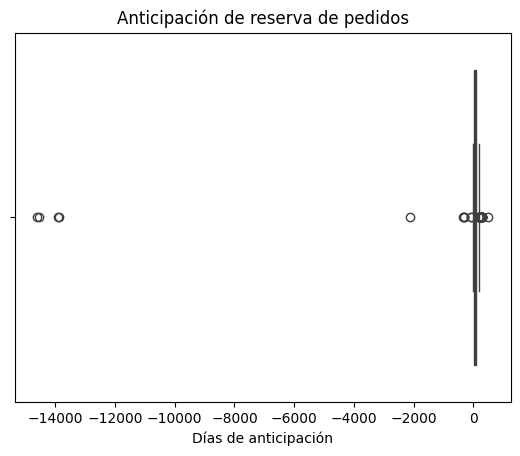

In [140]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

Claramente tenemos outliers, ya que no puede haber un evento que suceda previo a su reserva. 

Vamos a ver cuantos datos son

In [142]:
pedidos_mal_fecha = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']<=0]['Title'].count()
print("Cantidad de pedidos donde sucedió el evento antes de la reserva (mal cargados):", pedidos_mal_fecha)

Cantidad de pedidos donde sucedió el evento antes de la reserva (mal cargados): 29


In [143]:
df_pedidos_wc_sh = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']>0]

Text(0.5, 0, 'Días de anticipación')

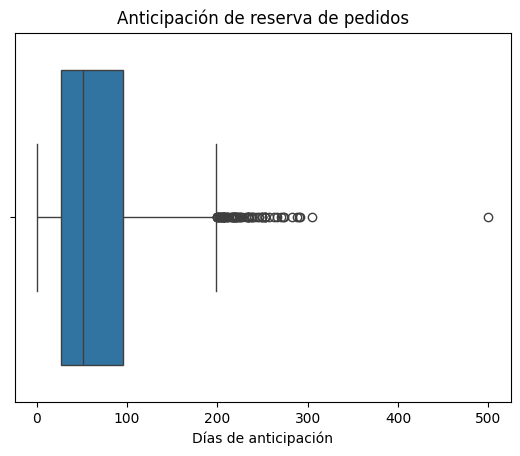

In [144]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

Por otro lado vamos a eliminar al outlier de apróximadamente 500 días independientemente de si está bien o mal cargado. Solo por el concepto de ser un outlier

In [145]:
df_pedidos_wc_sh = df_pedidos_wc_sh[df_pedidos_wc_sh['anticipacion_reserva_dias']<400]

Text(0.5, 0, 'Días de anticipación')

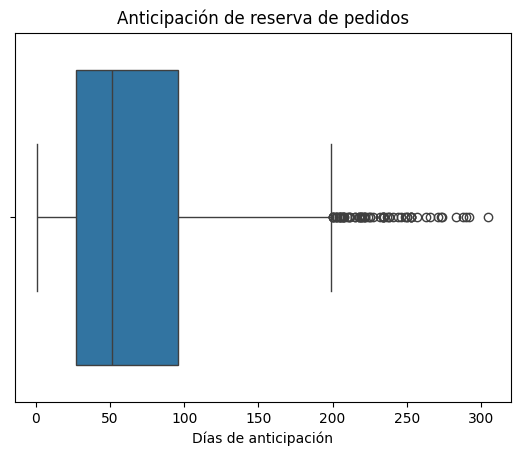

In [146]:
sns.boxplot(x=df_pedidos_wc_sh['anticipacion_reserva_dias'])
plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')

Ahora podemos graficar con un histograma la distribución de días de anticipación de reserva de un evento

Text(0, 0.5, 'Frecuencia')

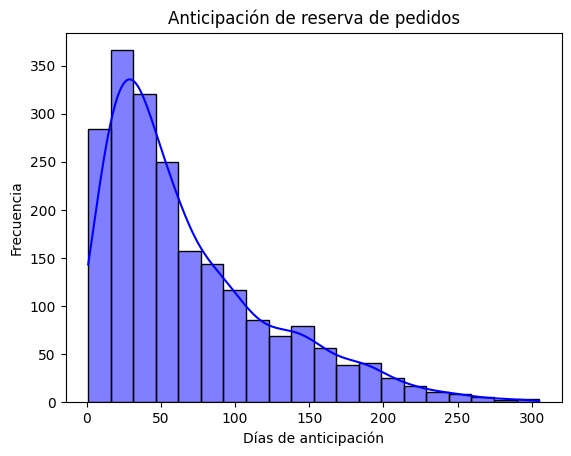

In [147]:
sns.histplot(df_pedidos_wc_sh['anticipacion_reserva_dias'], kde=True, color='blue', bins=20)

plt.title('Anticipación de reserva de pedidos')
plt.xlabel('Días de anticipación')
plt.ylabel('Frecuencia')

In [148]:
df_pedidos_wc_sh['anticipacion_reserva_dias'].describe()

count    2080.000000
mean       68.427885
std        56.179800
min         1.000000
25%        27.000000
50%        51.000000
75%        96.000000
max       305.000000
Name: anticipacion_reserva_dias, dtype: float64